<a href="https://colab.research.google.com/github/JayNguyen-123/Text_Genaration/blob/main/Pytorch_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Text Generations using GRUs
- Implement and training Text Generations in Recurrent Neural Network(RNN)


In [1]:
!pip install unidecode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.2 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:

# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('Training on CPU; consider making n_epochs very small.')


train_df = pd.read_csv('/content/drive/MyDrive/train-txt-gen.csv')
author = train_df[train_df['author'] == 'EAP']['text']
author[:5]


Training on GPU!


,text
0,"This process, however, afforded me no means of..."
2,"In his left hand was a gold snuff box, from wh..."
6,"The astronomer, perhaps, at this point, took r..."
7,The surcingle hung in ribands from my body.
8,I knew that you could not say to yourself 'ste...


In [3]:
text = list(author[:100])

def joinString(text):
  return ' '.join(string for string in text)

text = joinString(text)
len(text.split())


2802

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation)
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### N-Grams Language Modeling
- An n-gram is a sequence of n words: a 2-gram (which we’ll call
bigram) is a two-word sequence of words like The water, or water of, and a 3-
gram (a trigram) is a three-word sequence of words like The water of, or water
of Walden.

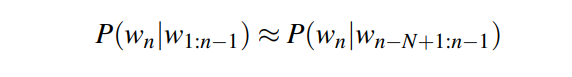

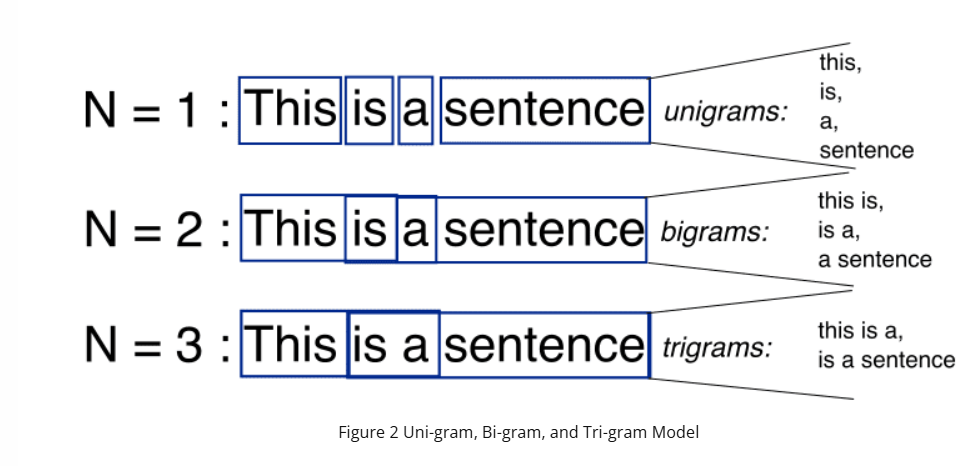

In [5]:


trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])



[(['this', 'process'], 'however'), (['process', 'however'], 'afforded'), (['however', 'afforded'], 'mean')]


In [6]:
vocab = set(test_sentence)
vocab_len = len(vocab)
word2index = {word: i for i, word in enumerate(vocab)}


In [7]:
inp = []
tar = []
for context, target in trigrams:
  context_idexs = torch.tensor([word2index[w] for w in context], dtype=torch.long)
  inp.append(context_idexs)
  targ = torch.tensor([word2index[target]], dtype=torch.long)
  tar.append(targ)


### Gated Recurrent Unit (GRU)
- Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network.
- GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.



In [8]:
# GRU model for Text Generation

import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.encoder = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, batch_first=True, bidirectional=False)
    self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    input = self.encoder(input.view(1, -1))
    output, hidden = self.gru(input.view(1, 1, -1), hidden)
    output = self.decoder(output.view(1, -1))
    return output, hidden

  def init_hidden(self):
    return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))



In [9]:
import time, math

def time_since(since):
  s = time.time() - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds' % (m, s)



In [10]:
def train(inpt, target):
  hidden = decoder.init_hidden().cuda()
  decoder.zero_grad()
  loss = 0

  for c in range(chunk_len):
    output, hidden = decoder(inp[c].cuda(), hidden)
    loss += criterion(output, target[c].cuda())

  loss.backward()
  decoder_optimizer.step()

  return loss.data.item()/chunk_len

In [12]:
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(vocab_len, hidden_size, vocab_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
  decoder.cuda()
for epoch in range(1, n_epochs + 1):
  loss = train(inp, tar)
  loss_avg += loss

  if epoch % print_every == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch/n_epochs * 50, loss))

  if epoch % plot_every == 0:
    all_losses.append(loss_avg/plot_every)
    loss_avg = 0

 59s (100 16%) 0.0001]
 57s (200 33%) 0.0001]
 53s (300 50%) 0.0001]


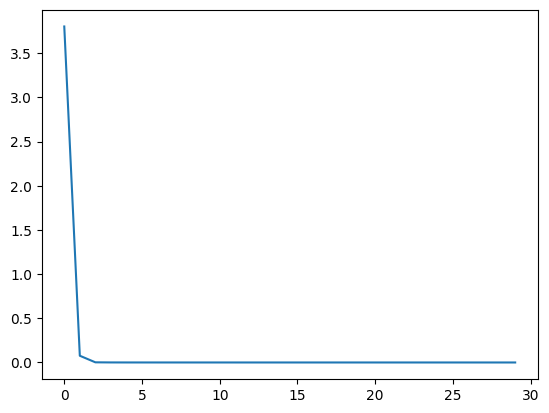

In [13]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


In [19]:
# Generating the text

def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):

        prime_input = torch.tensor([word2index[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted word to string and use as next input
        predicted_word = list(word2index.keys())[list(word2index.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str


In [20]:
print(evaluate("this process", 40, temperature=1))


this process however afforded mean ascertaining dimension dungeon i might make circuit return point whence i set out without aware fact perfectly uniform seemed wall in left hand gold snuff box which capered hill cutting manner fantastic step took snuff incessantly air


In [22]:
print(evaluate("i knew that", 30, temperature=1))


i knew that stage stage upon pit stomach produced apparently pressure knee mem hell answer too let composition defective let emendation wrought mere arrangement form let emendation submitted every artist world necessity admitted
